In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load the dataset and inspect:

In [53]:
df = pd.read_csv('cafe_sales.csv')

In [54]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    10000 non-null  object
 1   Item              9667 non-null   object
 2   Quantity          9862 non-null   object
 3   Price Per Unit    9821 non-null   object
 4   Total Spent       9827 non-null   object
 5   Payment Method    7421 non-null   object
 6   Location          6735 non-null   object
 7   Transaction Date  9841 non-null   object
dtypes: object(8)
memory usage: 625.1+ KB


In [56]:
df.shape

(10000, 8)

In [57]:
categorical_cols = ['Item', 'Payment Method', 'Location']
for col in categorical_cols:
  print(f"\n{col} unique values:")
  print(df[col].value_counts(dropna=False))


Item unique values:
Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
NaN          333
ERROR        292
Name: count, dtype: int64

Payment Method unique values:
Payment Method
NaN               2579
Digital Wallet    2291
Credit Card       2273
Cash              2258
ERROR              306
UNKNOWN            293
Name: count, dtype: int64

Location unique values:
Location
NaN         3265
Takeaway    3022
In-store    3017
ERROR        358
UNKNOWN      338
Name: count, dtype: int64


Handling missing values:

In [58]:
df.replace(["ERROR", "UNKNOWN", ""], np.nan, inplace=True)

In [59]:
df.isna().sum()

,0
Transaction ID,0
Item,969
Quantity,479
Price Per Unit,533
Total Spent,502
Payment Method,3178
Location,3961
Transaction Date,460


In [60]:
missing_summary = df.isna().sum()
missing_percentage = (df.isna().sum() / len(df)) * 100
missing_df = pd.DataFrame({
        'Missing Count': missing_summary,
        'Missing Percentage': missing_percentage
    })

print("Missing Values Summary:")
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Percentage', ascending=False))

Missing Values Summary:
                  Missing Count  Missing Percentage
Location                   3961               39.61
Payment Method             3178               31.78
Item                        969                9.69
Price Per Unit              533                5.33
Total Spent                 502                5.02
Quantity                    479                4.79
Transaction Date            460                4.60


In [61]:
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

#Data type conversion to int

df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce")
df["Price Per Unit"] = pd.to_numeric(df["Price Per Unit"], errors="coerce")
df["Total Spent"] = pd.to_numeric(df["Total Spent"], errors="coerce")
df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")

for col in numerical_cols:
        mean_value = df[col].mean(skipna=True)
        print(f"Imputing {col} with mean value: {mean_value}")
        df[col] = df[col].fillna(mean_value)

print(df.isna().sum())

for col in categorical_cols:
     df[col] = df[col].astype('object')
     df[col] = df[col].fillna('Missing')

# For Transaction Date: remove rows with missing dates as they are critical
df = df.dropna(subset=['Transaction Date'])

print(df.isna().sum())

Imputing Quantity with mean value: 3.028463396702027
Imputing Price Per Unit with mean value: 2.949984155487483
Imputing Total Spent with mean value: 8.924352495262161
Transaction ID         0
Item                 969
Quantity               0
Price Per Unit         0
Total Spent            0
Payment Method      3178
Location            3961
Transaction Date     460
dtype: int64
Transaction ID      0
Item                0
Quantity            0
Price Per Unit      0
Total Spent         0
Payment Method      0
Location            0
Transaction Date    0
dtype: int64


In [62]:
df.shape

(9540, 8)

Identify and remove duplicate records.

In [63]:
duplicate_ids = df['Transaction ID'].duplicated().sum()
print(f"\nDuplicate Transaction IDs: {duplicate_ids}")


Duplicate Transaction IDs: 0


Detect and treat outliers

In [64]:
def detect_outliers_iqr(df, column, lower_factor=1.5, upper_factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (lower_factor * IQR)
    upper_bound = Q3 + (upper_factor * IQR)

    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)

    print(f"Column {column}:")
    print(f"  - Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  - Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"  - Outliers detected: {outliers.sum()} ({outliers.sum()/len(df)*100:.2f}%)")

    return outliers, lower_bound, upper_bound

# Apply outlier detection to numerical columns
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
print("\nOutlier Detection using IQR method:")

outlier_info = {}
for col in numerical_cols:
    outliers, lower_bound, upper_bound = detect_outliers_iqr(df, col)
    outlier_info[col] = {
        'outliers': outliers,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }


Outlier Detection using IQR method:
Column Quantity:
  - Q1: 2.0, Q3: 4.0, IQR: 2.0
  - Lower bound: -1.0, Upper bound: 7.0
  - Outliers detected: 0 (0.00%)
Column Price Per Unit:
  - Q1: 2.0, Q3: 4.0, IQR: 2.0
  - Lower bound: -1.0, Upper bound: 7.0
  - Outliers detected: 0 (0.00%)
Column Total Spent:
  - Q1: 4.0, Q3: 12.0, IQR: 8.0
  - Lower bound: -8.0, Upper bound: 24.0
  - Outliers detected: 250 (2.62%)


In [65]:
for col in numerical_cols:
    outliers = outlier_info[col]['outliers']
    removed_count = outliers.sum()
    df = df[~outliers]
    print(f"Column {col}: removed {removed_count} outliers")

Column Quantity: removed 0 outliers
Column Price Per Unit: removed 0 outliers
Column Total Spent: removed 250 outliers


In [66]:
df.shape

(9290, 8)

No standardisation of categorical variables required

Univariate

In [67]:
df.describe()

,Quantity,Price Per Unit,Total Spent,Transaction Date
count,9290.000000,9290.000000,9290.000000,9290
mean,2.975086,2.898385,8.482077,2023-07-01 22:21:52.895586560
min,1.000000,1.000000,1.000000,2023-01-01 00:00:00
25%,2.000000,2.000000,4.000000,2023-04-01 00:00:00
50%,3.000000,3.000000,8.000000,2023-07-02 00:00:00
75%,4.000000,4.000000,12.000000,2023-10-02 00:00:00
max,5.000000,5.000000,20.000000,2023-12-31 00:00:00
std,1.365832,1.216191,5.300401,NaN


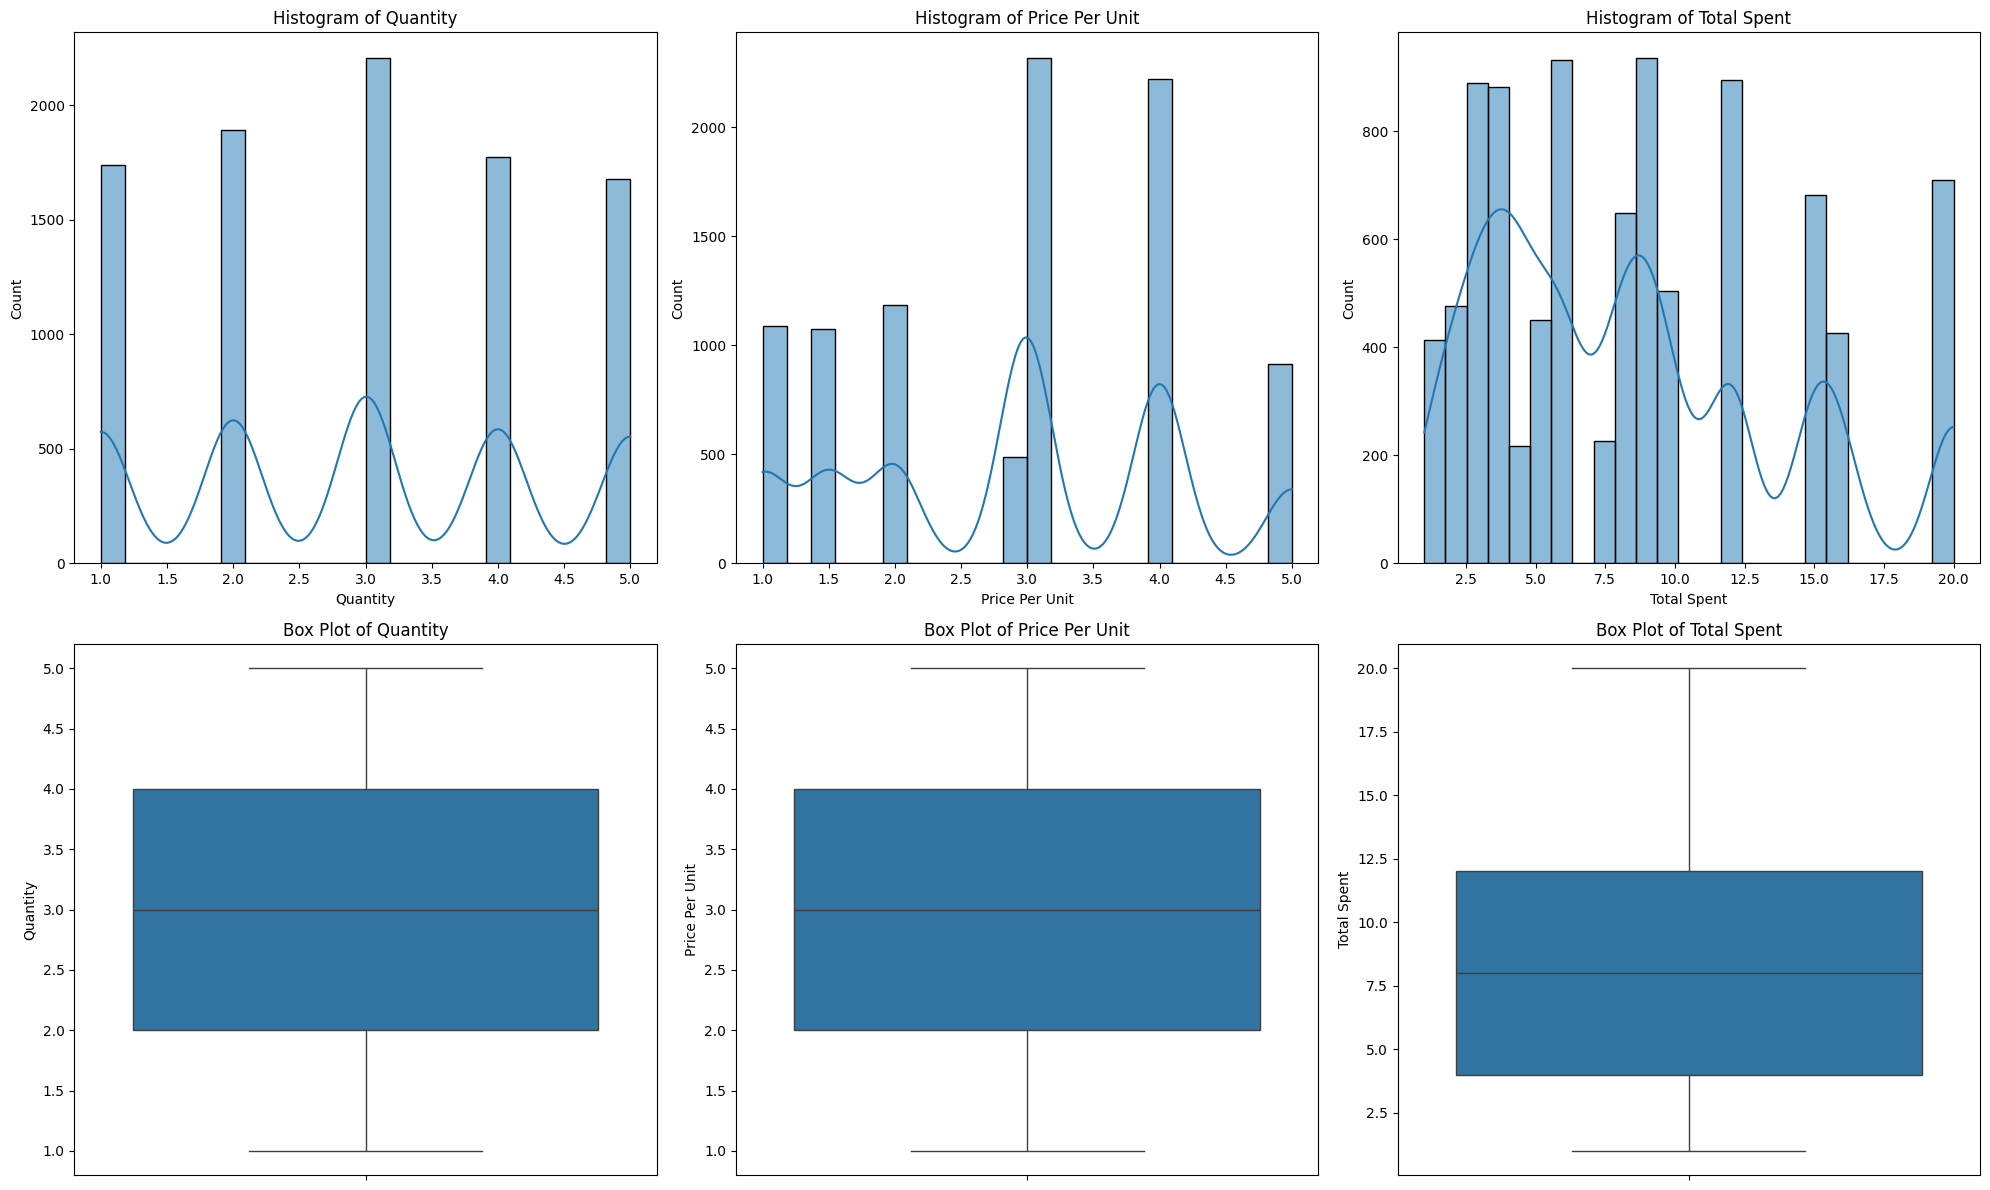

In [68]:
numerical_cols = ['Quantity', 'Price Per Unit', 'Total Spent']
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], kde=True, ax=axes[0, i])
    sns.boxplot(y=df[col], ax=axes[1, i])
    axes[0, i].set_title(f'Histogram of {col}')
    axes[1, i].set_title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Bivariate analysis

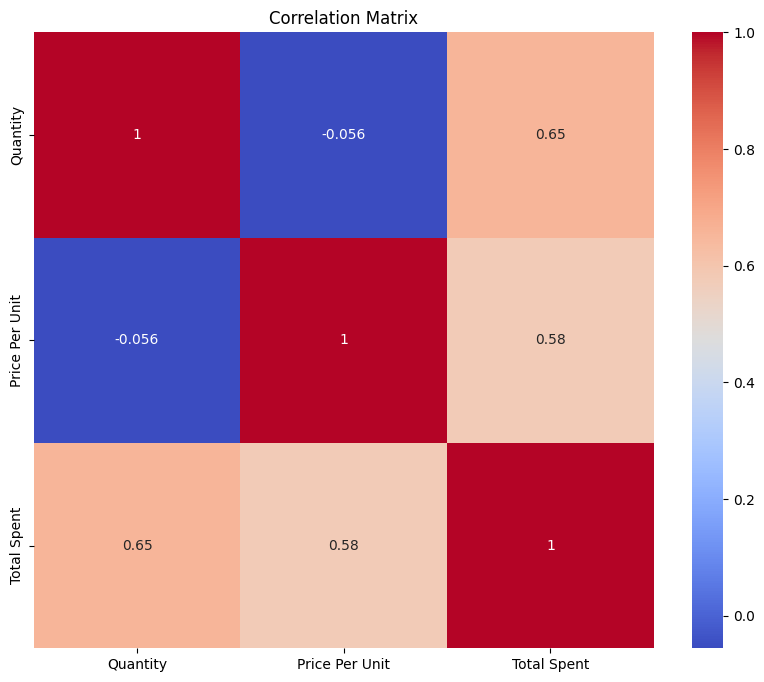

In [69]:
# Correlation Matrix
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

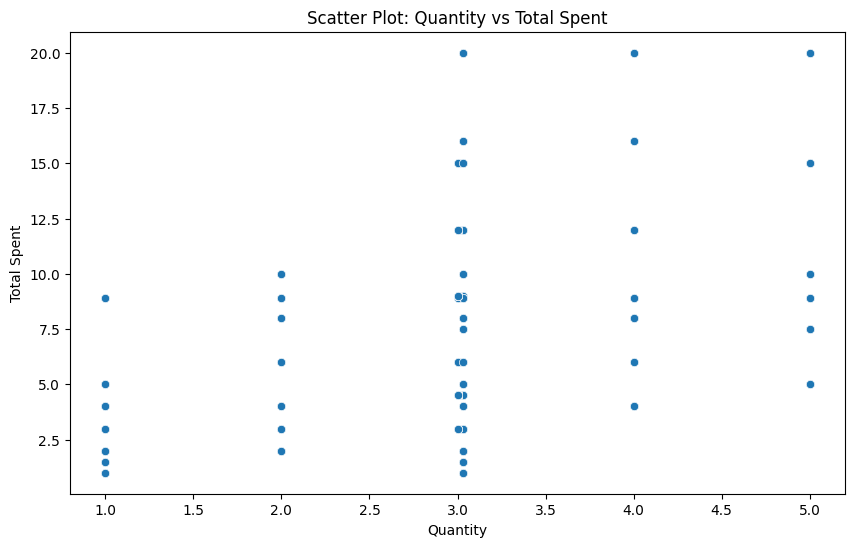

In [70]:
# Scatter Plots
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Total Spent', data=df)
plt.title('Scatter Plot: Quantity vs Total Spent')
plt.show()

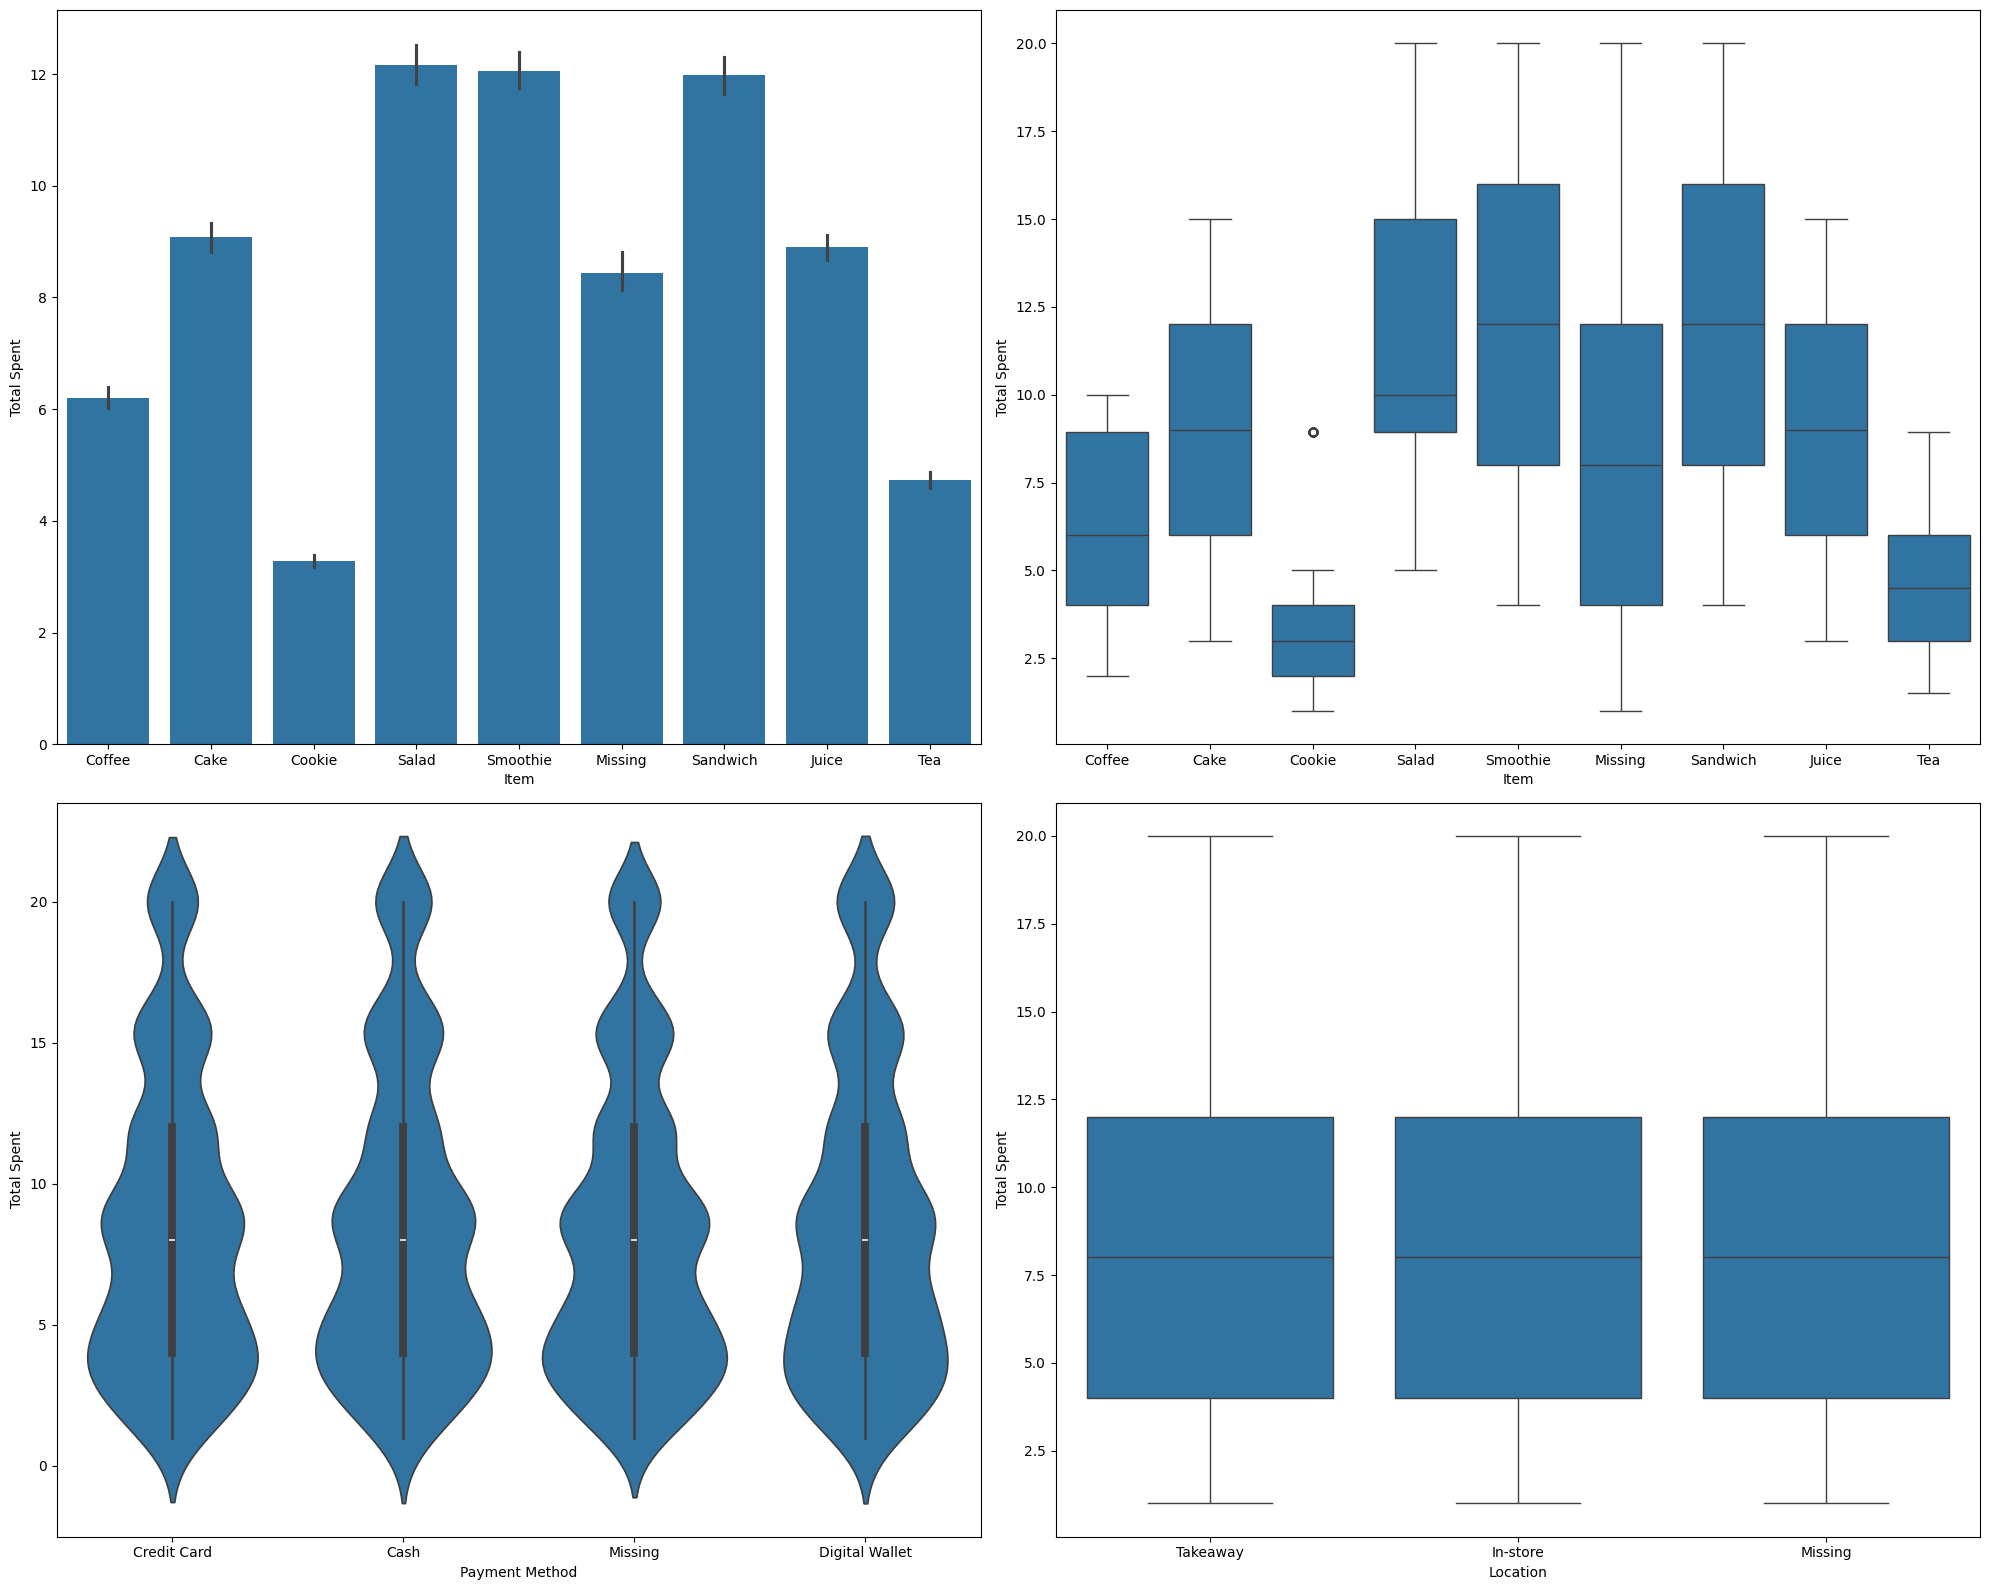

In [71]:
# Bar Plots and Box Plots for Categorical vs Numerical
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
sns.barplot(x='Item', y='Total Spent', data=df, ax=axes[0, 0])
sns.boxplot(x='Item', y='Total Spent', data=df, ax=axes[0, 1])
sns.violinplot(x='Payment Method', y='Total Spent', data=df, ax=axes[1, 0])
sns.boxplot(x='Location', y='Total Spent', data=df, ax=axes[1, 1])
plt.tight_layout()
plt.show()

Multivariate Analysis

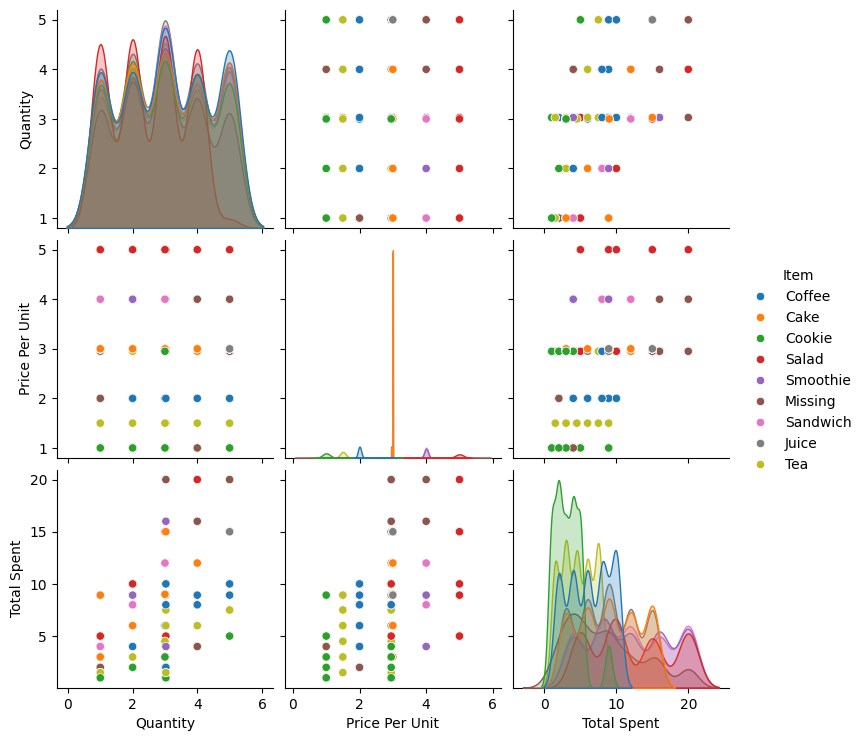

In [72]:
# Pair Plot
sns.pairplot(df[numerical_cols + ['Item']], hue='Item')
plt.show()

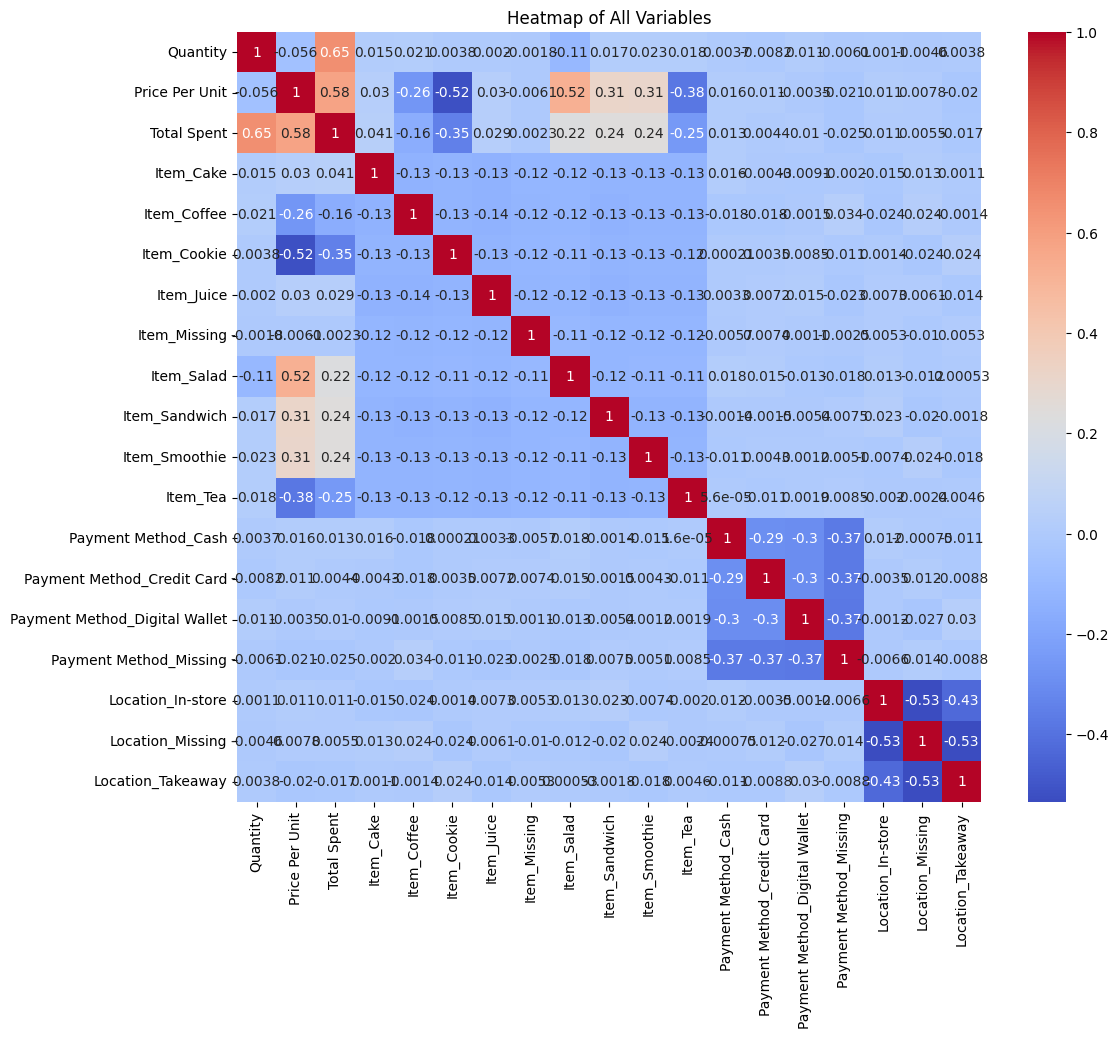

In [73]:
# Heatmap of Correlations
# we need to encode categorical cols if we want to include them in the correlation matrix
df_encoded = pd.get_dummies(df[categorical_cols])

df_corr = pd.concat([df[numerical_cols], df_encoded], axis=1)

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of All Variables')
plt.show()

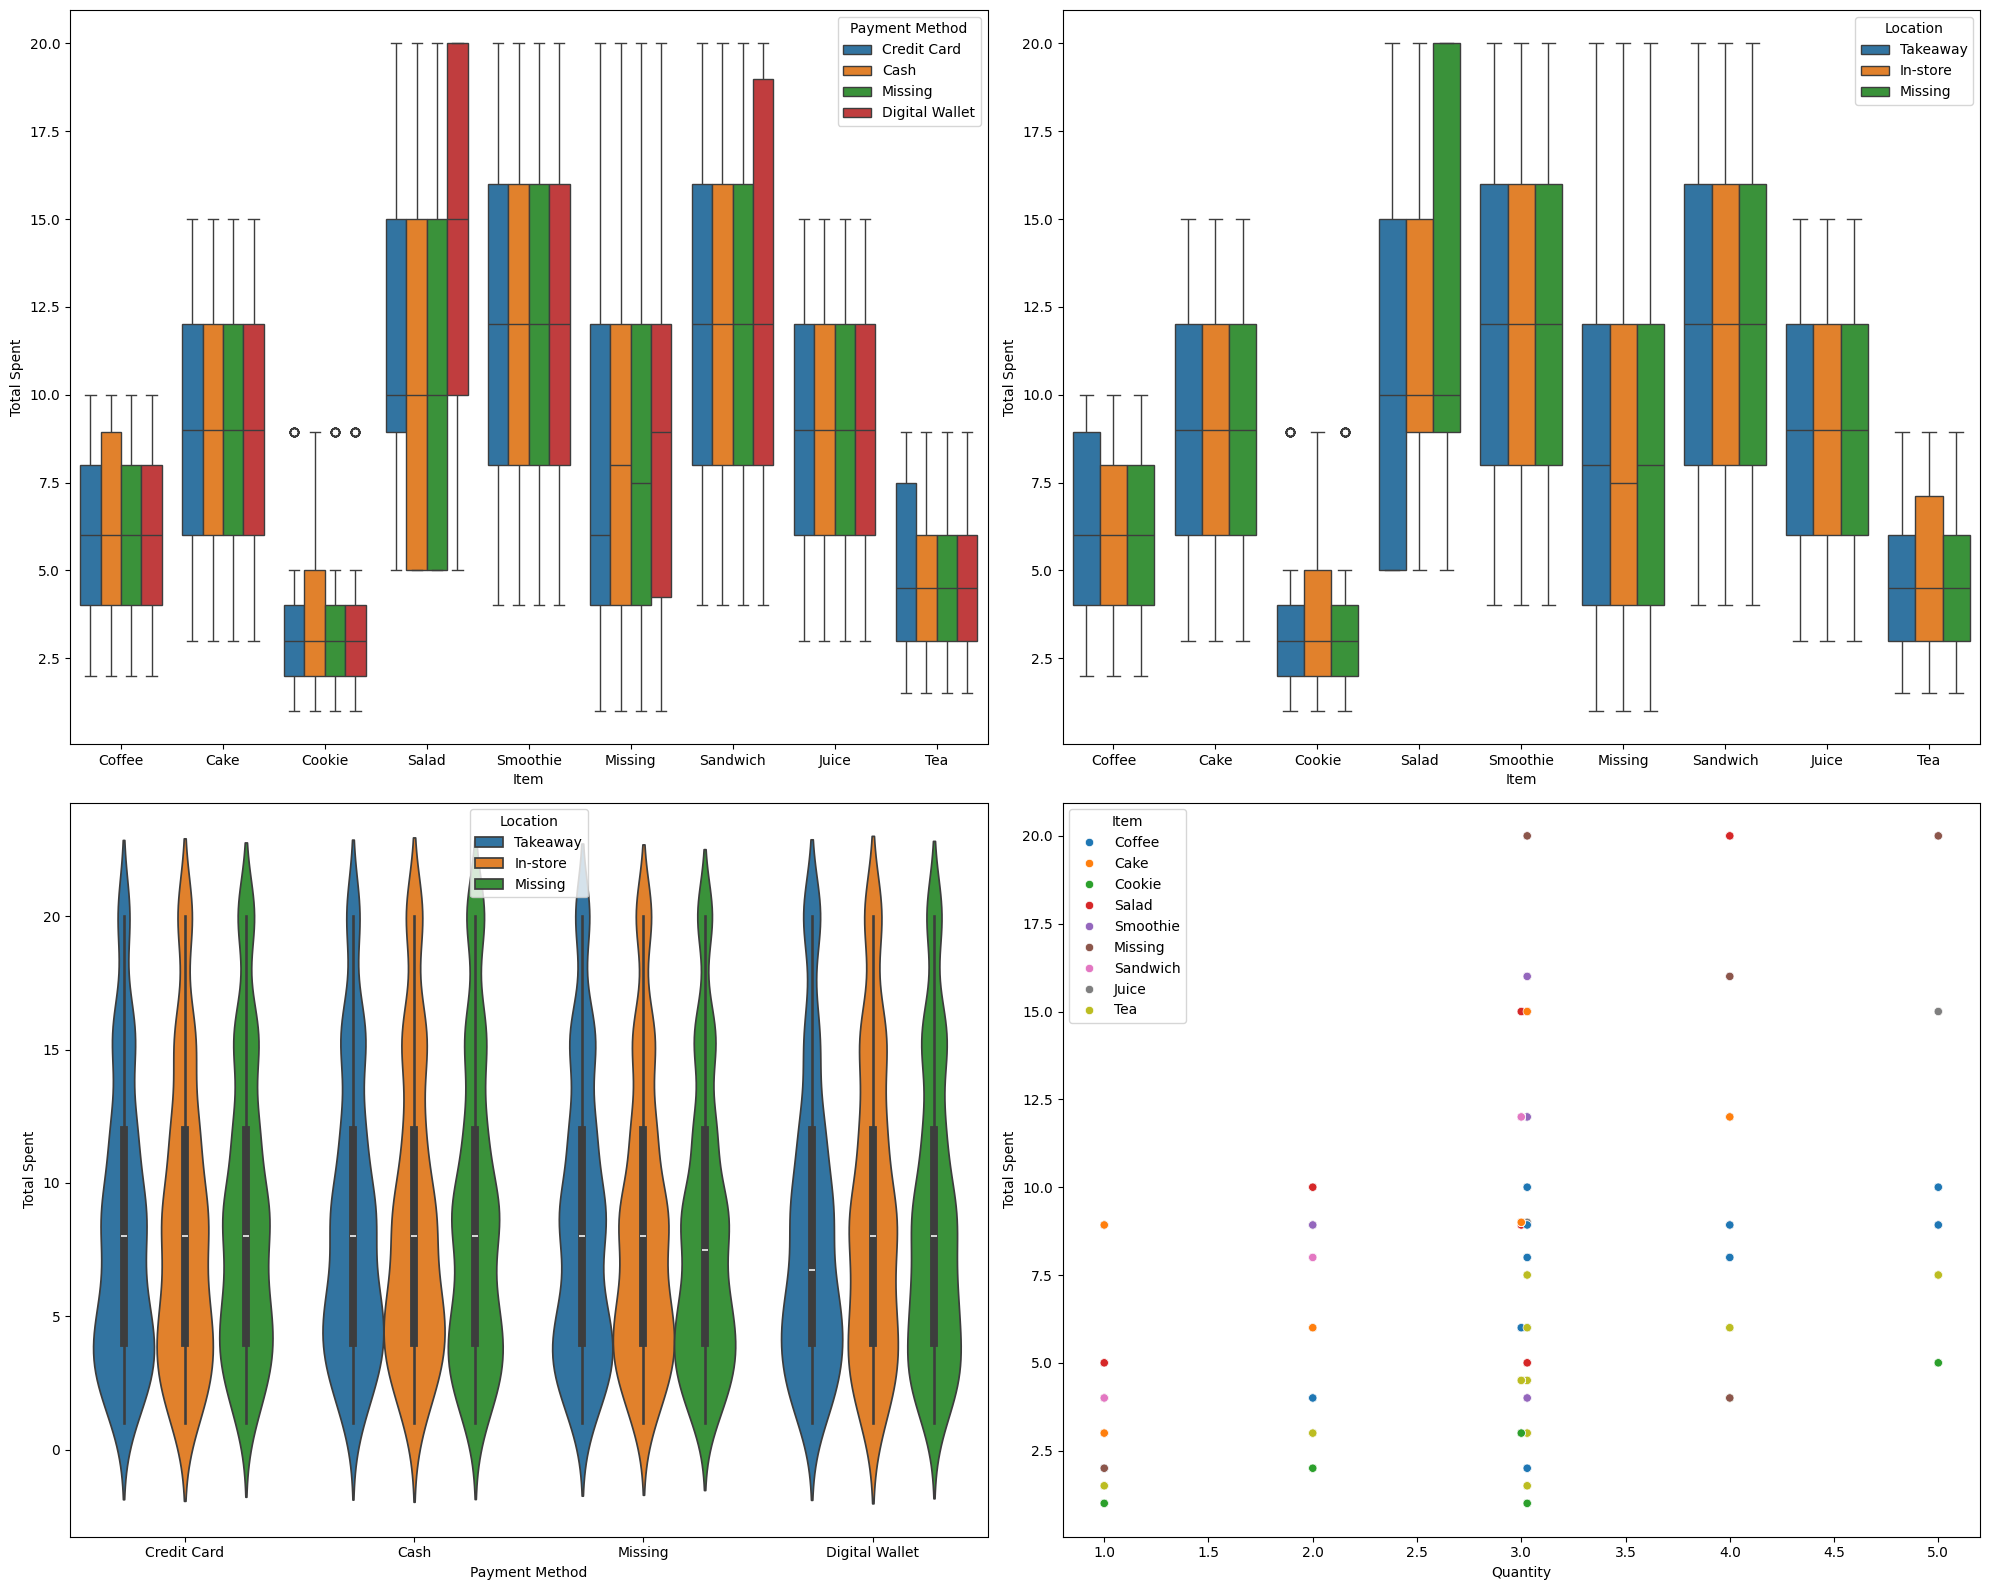

In [74]:
# Grouped Comparisons
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
sns.boxplot(x='Item', y='Total Spent', hue='Payment Method', data=df, ax=axes[0, 0])
sns.boxplot(x='Item', y='Total Spent', hue='Location', data=df, ax=axes[0, 1])
sns.violinplot(x='Payment Method', y='Total Spent', hue='Location', data=df, ax=axes[1, 0])
sns.scatterplot(x='Quantity', y='Total Spent', hue='Item', data=df, ax=axes[1, 1])
plt.tight_layout()
plt.show()